In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

[*********************100%***********************]  1 of 1 completed


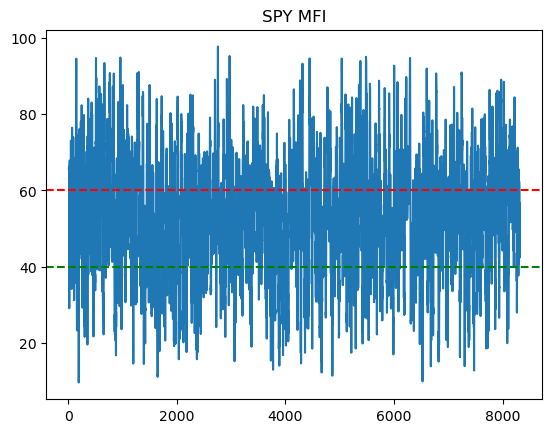

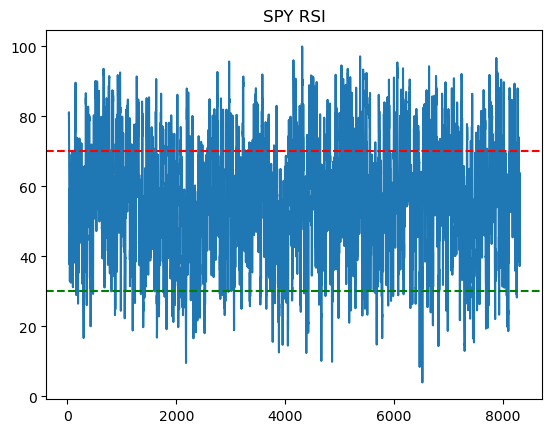

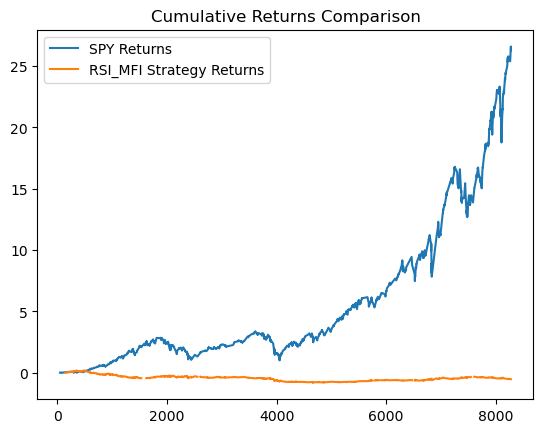

Price,Date,Close,High,Low,Open,Volume,Average_price,Money_flow,Positive_flow,Negative_flow,MFI,signal,MFI_strategy,RSI,RSI_strategy,RSI_signal,full_strategy,strategy,Asset_returns,strategy_returns
49,1993-04-12,24.892912,24.910235,24.754329,24.788975,348500,24.852492,8.661093e+06,8.661093e+06,0.000000e+00,71.574934,NaN,1.0,51.923564,NaN,NaN,NaN,NaN,NaN,NaN
50,1993-04-13,24.944864,25.031478,24.858250,24.875573,146100,24.944864,3.644445e+06,3.644445e+06,0.000000e+00,73.107586,NaN,-1.0,51.922800,0.0,NaN,-1.0,NaN,0.002087,NaN
70,1993-05-11,24.736990,24.736990,24.563762,24.633053,42600,24.679247,1.051336e+06,1.051336e+06,0.000000e+00,70.146660,NaN,-1.0,52.083419,0.0,NaN,-1.0,NaN,-0.006264,NaN
71,1993-05-12,24.702345,24.719668,24.633054,24.633054,31000,24.685022,7.652357e+05,7.652357e+05,0.000000e+00,76.463910,NaN,-1.0,62.499759,0.0,NaN,-1.0,NaN,-0.007655,NaN
72,1993-05-13,24.407866,24.598417,24.390543,24.598417,129100,24.465608,3.158510e+06,0.000000e+00,3.158510e+06,75.011014,NaN,-1.0,54.944572,0.0,NaN,-1.0,NaN,-0.019485,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8219,2025-09-24,659.152222,662.651890,657.726442,662.552209,68082200,659.843518,4.492360e+10,0.000000e+00,4.492360e+10,70.595624,-1.0,-1.0,70.938194,-1.0,-1.0,-2.0,-1.0,25.479514,-0.514106
8228,2025-10-07,667.148621,671.007214,665.702880,670.558527,72020100,667.952905,4.810604e+10,0.000000e+00,4.810604e+10,70.484320,-1.0,-1.0,67.125307,-1.0,NaN,-2.0,-1.0,25.800746,-0.520001
8261,2025-11-21,657.088379,662.592074,648.932425,653.120063,123956200,656.204293,8.134059e+10,0.000000e+00,8.134059e+10,27.927224,-1.0,-1.0,33.401601,-1.0,NaN,-2.0,-1.0,25.396606,-0.512762
8274,2025-12-11,687.139526,687.219308,680.160150,683.121431,86173700,684.839661,5.901517e+10,5.901517e+10,0.000000e+00,70.806873,NaN,1.0,88.024075,-1.0,-1.0,0.0,-1.0,26.603823,-0.535046


In [ ]:
ticker = "SPY"
interval = '1d'
period = 'max'

MFI_LENGTH = 14
MFI_OVERBOUGHT = 70
MFI_OVERSOLD = 30

LOOKBACK = -2000

RSI_LENGTH = 14
RSI_OVERBOUGHT = 70
RSI_OVERSOLD = 30

def get_data(ticker, lookback=LOOKBACK, interval=interval, period=period):
    df = yf.download(ticker, period = period, auto_adjust=True, interval=interval)
    #reset index to get datetime as a column
    df = df.reset_index()

    df.sort_index(inplace=True)
    df.columns = df.columns.get_level_values(0)

    #only return data after lookback
    return df.iloc[lookback:,:]

def add_RSI(df, RSI_LENGTH):

    delta = df['Close'].diff()

    #separate gains and losses
    gain = (delta.where(delta > 0, 0))
    loss = (-delta.where(delta < 0, 0))

    #calculate average gain and loss
    avg_gain = gain.rolling(window=RSI_LENGTH).mean()
    avg_loss = loss.rolling(window=RSI_LENGTH).mean()

    #calculate RSI
    rs = avg_gain / avg_loss 
    df['RSI'] = 100 - (100 / (1 + rs))

    #plot RSI
    plt.figure()
    plt.plot(df['RSI'])
    plt.axhline(RSI_OVERBOUGHT, color='red', linestyle='--')    
    plt.axhline(RSI_OVERSOLD, color='green', linestyle='--')
    plt.title(f'{ticker} RSI')

    return df.dropna()

def RSI_strategy(df, OVERBOUGHT = RSI_OVERBOUGHT, OVERSOLD = RSI_OVERSOLD):
    df['RSI_strategy'] = 0

    conditions = [
        (df['RSI'] > OVERBOUGHT), 
        (df['RSI'] < OVERSOLD)   ]
    choices = [-1, 1]
    
    df['RSI_signal'] = np.select(conditions, choices, default=np.nan)

    df['RSI_strategy'] = df['RSI_signal'].ffill()
    df['RSI_strategy'] = df['RSI_strategy'].fillna(0)
    df['RSI_strategy'] = df['RSI_strategy'].shift(1)

    return df

def add_MFI(df, MFI_LENGTH):

    df['Average_price'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['Money_flow'] = df['Average_price'] * df['Volume']

    #initialize empty flows
    df['Positive_flow'] = 0
    df['Negative_flow'] = 0

    df['Positive_flow'] = np.where(df['Average_price'] > df['Average_price'].shift(1), df['Money_flow'], 0)
    df['Negative_flow'] = np.where(df['Average_price'] < df['Average_price'].shift(1), df['Money_flow'], 0)

    mfr = df['Positive_flow'].rolling(window=MFI_LENGTH).sum() / df['Negative_flow'].rolling(window=MFI_LENGTH).sum()
    df['MFI'] = 100 - (100 / (1 + mfr))

    plt.figure()
    plt.plot(df['MFI'])
    plt.axhline(MFI_OVERBOUGHT, color='red', linestyle='--')    
    plt.axhline(MFI_OVERSOLD, color='green', linestyle='--')
    plt.title(f'{ticker} MFI')

    return df.dropna()

def MFI_strategy(df, OVERBOUGHT = MFI_OVERBOUGHT, OVERSOLD = MFI_OVERSOLD):
    # 1. Create purely Buy (1) and Sell (-1) signals, use NaN for "do nothing"
    conditions = [
        (df['MFI'] > OVERBOUGHT), # Condition 1: Short
        (df['MFI'] < OVERSOLD)    # Condition 2: Long
    ]
    choices = [-1, 1]
    
    # Use np.select to assign 1 or -1, but default to NaN (np.nan) instead of 0
    df['signal'] = np.select(conditions, choices, default=np.nan)

    # 2. Forward Fill (The Memory)
    # This says: "If today is NaN, copy yesterday's position."
    df['MFI_strategy'] = df['signal'].ffill()

    # 3. Handle the start (replace initial NaNs with 0)
    df['MFI_strategy'] = df['MFI_strategy'].fillna(0)

    # 4. Shift to trade "tomorrow"
    df['MFI_strategy'] = df['MFI_strategy'].shift(1)

    return df

def add_full_strategy(df):
    df['full_strategy'] = df['MFI_strategy'] + df['RSI_strategy']

    conditions = [
        (df['full_strategy'] == 2), 
        (df['full_strategy'] == -2)   ]
    choices = [1, -1]
    
    df['signal'] = np.select(conditions, choices, default=np.nan)

    #df['strategy'] = df['signal'].ffill()
    #df['strategy'] = df['signal'].fillna(0)
    df['strategy'] = df['signal'].shift(1)

    return df

def test_strategy(df):
    df['Asset_returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['strategy_returns'] = (1 + df['Close'].pct_change() * df['strategy']).cumprod() - 1

    plt.figure()
    plt.plot(df['Asset_returns'], label=f'{ticker} Returns')
    plt.plot(df['strategy_returns'], label='RSI_MFI Strategy Returns')
    plt.legend()
    plt.title('Cumulative Returns Comparison')
    plt.show()

    return df

def main():
    df = get_data(ticker, LOOKBACK, interval, period)
    df = add_MFI(df, MFI_LENGTH)
    df = MFI_strategy(df, OVERBOUGHT, OVERSOLD)
    df = add_RSI(df, RSI_LENGTH)
    df = RSI_strategy(df, OVERBOUGHT, OVERSOLD)
    df = add_full_strategy(df)
    df = test_strategy(df)
    plt.show()
    return df

df = main()
df